In [2]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from pymc import sampling_jax
import pytensor as pt
import arviz as az
import altair as alt
pm.__version__

/home/aurimas/micromamba/envs/pymc5/lib/python3.11/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


'5.0.2'

The data in data(bangladesh) are 1934 women from the 1989 Bangladesh Fertility
Survey. For each woman, we know which district she lived in, her number
of living.children, her age.centered, whether she lived in an urban center,
and finally whether or not she used contraception (use.contraception).
In the lecture, we estimated the total effect of urban residence on contraceptive
use. Using the DAG from lecture, or your own version if you prefer, now estimate
only the direct effect of urban residence on contraceptive use.

In [3]:
from jupyterlab_dagitty import DAG

In [4]:
m_bias_code = """
dag {
    district -> use.contraception;
    urban -> use.contraception;
    district -> urban;
    living.children -> use.contraception;
    age.centered -> living.children;
    age.centered -> use.contraception;
    urban -> living.children;
    use.contraception [outcome]
    urban [exposure]
}"""
DAG(m_bias_code)

In [5]:
bangladesh = pd.read_csv('../../../datasets/bangladesh.csv')

#factorize districts
d_idx, districts = pd.factorize(bangladesh['district'], sort=True)
#factorize out children counts; we will assume a monotonic effect for them
children_idx, children = pd.factorize(bangladesh['living.children'], sort=True)
std_age = bangladesh[['age.centered']].apply(lambda x: (x-x.mean())/ x.std(), axis=0)

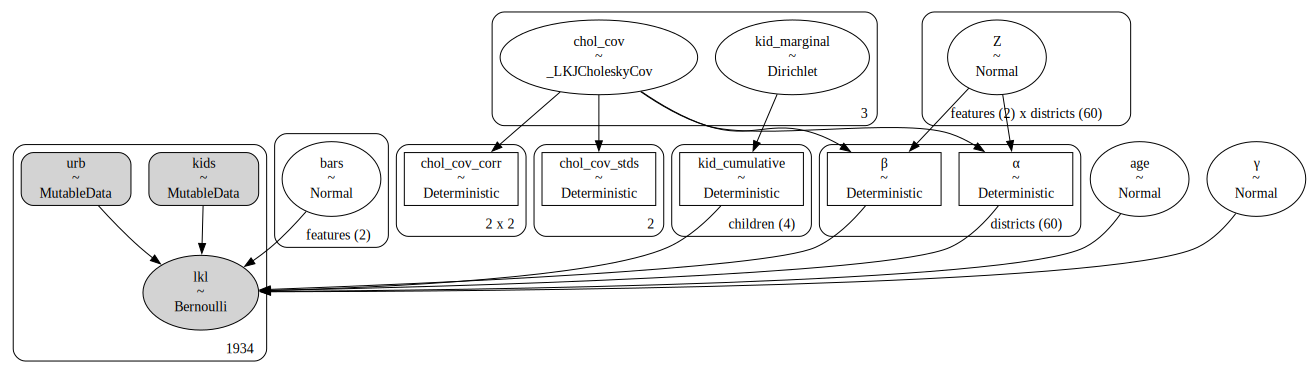

In [6]:
with pm.Model(coords = {
    "districts": districts,
    "children": children,
    "features": ["district", "urban"],   
    "urbanity": ["rural", "urban"] 
}) as ex1_model_1:
    
    #district & urbanity features
    urbanity = pm.MutableData("urb", bangladesh['urban'].values, coords="urbanity")   
    kids = pm.MutableData('kids', children_idx, coords="children")
    σ = pm.Exponential.dist(1.0, shape=2)
    bars = pm.Normal("bars", 0, 1, dims="features")    
    chol, corr, stds = pm.LKJCholeskyCov('chol_cov', n=2, eta=4, sd_dist=σ, compute_corr=True)

    Z = pm.Normal('Z', mu=0, sigma=1, dims=["features", "districts"])
    vals = pm.math.dot(chol, Z)
        
    α = pm.Deterministic("α", vals[0, :], dims="districts")
    β = pm.Deterministic("β", vals[1, :], dims="districts") 

    #monotonic effect on children    
    γ = pm.Normal("γ", 0, 1)    
    cutpoints = pm.Dirichlet("kid_marginal", a = np.ones((len(children) - 1,)))
    kid_impact = pm.Deterministic(
        "kid_cumulative", 
        pm.math.concatenate([pm.math.constant(0, ndim=1), cutpoints.cumsum(axis=0)], axis=0),
        dims=['children']
    )

    #age
    δ = pm.Normal("age", 0, 1)

    logit = bars[0] + bars[1]*urbanity #baseline effects
    logit += α[d_idx] + β[d_idx]*urbanity #effects of districts
    logit += kid_impact[kids]*γ  #baseline children effect
    # after some thinking & discussions, decided it is wrong to enclude this if goal is to estimate direct effect only
    #logit += kid_impact[kids]*γ[1]*urbanity #children effect in urban areas
    logit += std_age.values.reshape(-1,)*δ #age effect

    pm.Bernoulli("lkl", logit_p = logit, observed = bangladesh['use.contraception'].values)

pm.model_to_graphviz(ex1_model_1)

In [7]:
with ex1_model_1:
    ex1_trace_1 = sampling_jax.sample_blackjax_nuts()

Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:00:03.205636
Sampling...
Sampling time =  0:00:07.656309
Transforming variables...
Transformation time =  0:00:05.009780


In [10]:
az.summary(
    ex1_trace_1, 
    var_names=['bars', 'kid_cumulative', 'γ', 'chol_cov_corr', 'age'], 
    round_to=2,
    coords={"chol_cov_corr_dim_0": 0, "chol_cov_corr_dim_1": 1, "children": [2,3,4]}
    )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bars[district],-1.64,0.15,-1.91,-1.34,0.0,0.0,1619.44,1990.28,1.0
bars[urban],0.74,0.16,0.44,1.04,0.0,0.0,1901.95,2961.34,1.0
kid_cumulative[2],0.79,0.09,0.63,0.95,0.0,0.0,3703.42,2026.59,1.0
kid_cumulative[3],0.93,0.06,0.83,1.00,0.0,0.0,3511.07,1968.24,1.0
kid_cumulative[4],1.00,0.00,1.00,1.00,0.0,0.0,4164.58,4000.00,1.0
γ,1.34,0.16,1.05,1.66,0.0,0.0,2010.64,2462.44,1.0
chol_cov_corr,-0.52,0.19,-0.84,-0.15,0.0,0.0,1722.11,2431.59,1.0
age,-0.24,0.07,-0.36,-0.11,0.0,0.0,2493.31,3049.11,1.0


## Estimate the causal effect of urbanity

In [11]:
with ex1_model_1:
    pm.set_data({"urb": np.zeros((len(bangladesh),), dtype=np.int32)})
    rural_predictions = pm.sample_posterior_predictive(ex1_trace_1)
    pm.set_data({"urb": np.ones((len(bangladesh),), dtype=np.int32)})
    urban_predictions = pm.sample_posterior_predictive(ex1_trace_1)

In [12]:
direct_effect = pd.DataFrame((
    urban_predictions['posterior_predictive']['lkl'] - rural_predictions['posterior_predictive']['lkl']
).mean(dim=['lkl_dim_2']).to_numpy().ravel()).rename({0: "urbanity effect"}, axis=1)

alt.Chart(direct_effect).transform_density(
    'urbanity effect',
    as_=['urbanity effect', 'density'],
).mark_area().encode(
    x="urbanity effect:Q",
    y='density:Q',
)

alt.Chart(...)

In [13]:
direct_effect = pd.DataFrame({
    "urban" : urban_predictions['posterior_predictive']['lkl'].mean(dim=['lkl_dim_2']).to_numpy().ravel(),
    "rural" : rural_predictions['posterior_predictive']['lkl'].mean(dim=['lkl_dim_2']).to_numpy().ravel()
})

alt.Chart(direct_effect).transform_density(
    'rural',
    as_=['probability', 'density'],
).mark_area(opacity=0.4, color='red').encode(
    x="probability:Q",
    y='density:Q',
) + alt.Chart(direct_effect).transform_density(
    'urban',
    as_=['probability', 'density'],
).mark_area(opacity=0.4).encode(
    x="probability:Q",
    y='density:Q',
)

alt.LayerChart(...)

## EX 2 - causal effect of children

In [14]:
with ex1_model_1:
    pm.set_data({"kids": np.zeros((len(bangladesh),), dtype=np.int32)})
    kid1 = pm.sample_posterior_predictive(ex1_trace_1)
    pm.set_data({"kids": np.ones((len(bangladesh),), dtype=np.int32)})
    kid2 = pm.sample_posterior_predictive(ex1_trace_1)
    pm.set_data({"kids": np.ones((len(bangladesh),), dtype=np.int32)*2})
    kid3 = pm.sample_posterior_predictive(ex1_trace_1)
    pm.set_data({"kids": np.ones((len(bangladesh),), dtype=np.int32)*3})
    kid4 = pm.sample_posterior_predictive(ex1_trace_1)    
    

In [15]:
direct_effect = pd.DataFrame({
    "1" : kid1['posterior_predictive']['lkl'].mean(dim=['lkl_dim_2']).to_numpy().ravel(),
    "2" : kid2['posterior_predictive']['lkl'].mean(dim=['lkl_dim_2']).to_numpy().ravel(),
    "3" : kid3['posterior_predictive']['lkl'].mean(dim=['lkl_dim_2']).to_numpy().ravel(),
    "4" : kid4['posterior_predictive']['lkl'].mean(dim=['lkl_dim_2']).to_numpy().ravel()
})

alt.Chart(direct_effect).transform_density(
    '1',
    as_=['probability', 'density'],
).mark_area(opacity=0.4, color='red').encode(
    x="probability:Q",
    y='density:Q',
) + alt.Chart(direct_effect).transform_density(
    '2',
    as_=['probability', 'density'],
).mark_area(opacity=0.4).encode(
    x="probability:Q",
    y='density:Q',
) + alt.Chart(direct_effect).transform_density(
    '3',
    as_=['probability', 'density'],
).mark_area(opacity=0.4).encode(
    x="probability:Q",
    y='density:Q',
) + alt.Chart(direct_effect).transform_density(
    '4',
    as_=['probability', 'density'],
).mark_area(opacity=0.4).encode(
    x="probability:Q",
    y='density:Q',
)

alt.LayerChart(...)